
## Assessing Climate Change Impacts on Xantusia vigilis lizards and their Joshua tree habitats with Ensemble Species Distribution Models

*How well do a variety of species distribution models (SDMs) perform for current geographic ranges of the two species? How much will climate change constrict the two species’ distributions, as well as their overlap. What can we kearn about jointly projecting SDMs of climate change impacts on these and other symbiotic species.*

---

Author : [Daniel Furman](mailto:dryanfurman@gmail.com) **|** Harvey Mudd College **|** NSF Award (#1757952) **|** [Online Render of Notebook](https://nbviewer.jupyter.org/github/daniel-furman/ensemble-climate-projections/blob/main/Comparing_MLs.ipynb)

---

Scripts for reproducing analyses presented at SICB 2021 and [SCCUR 2019](https://drive.google.com/file/d/114wmqQgjkc5DHLQmVI19AvlTw4K_daYQ/view?usp=sharing) conferences. The notebook is contained within a [GitHub Repository](https://github.com/daniel-furman/ensemble-climate-projections) alongside its accompanying files and data.

### Part 1: Introduction to Study
---


* Workflow: `Data pre-processing` -> `Model fitting` -> `Assessment` -> `Baseline interpolation (1970-2000)` -> `Extrapolation across 21st century`

A blend of tree-based, machine learning classifiers performed best at predicting the current geographic ranges for Xant. and Ybrev. The overlap in baseline geographic range was roughly fifty percent (intersection/union). Substantial bioclimatic change is predicted to constrict the geographic ranges for both species, as well as reduce species overlap by ~56% from baseline conditions, on average. Areas with a high likelihood of future species overlap were then pinpointed, to target ecological conservation for Mojave Desert populations of Xant. reliant on fallen Joshua trees for shelter.

### Part 2: Constructing Soft Voting Machine Learning Ensemble
---

In [1]:
# train classifiers for species distribution models via 10-fold CV
exec(open('ML_sdms_train.py').read())

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8608,0.9220,0.8606,0.8629,0.8606,0.7215,0.7236,2.3600
et,Extra Trees Classifier,0.8559,0.9218,0.8558,0.8576,0.8557,0.7117,0.7135,0.2800
gbc,Gradient Boosting Classifier,0.8529,0.9173,0.8526,0.8558,0.8525,0.7056,0.7086,0.1630
rf,Random Forest Classifier,0.8509,0.9227,0.8507,0.8530,0.8506,0.7017,0.7038,0.3760
lightgbm,Light Gradient Boosting Machine,0.8480,0.9145,0.8478,0.8495,0.8477,0.6958,0.6974,0.0550
xgboost,Extreme Gradient Boosting,0.8430,0.9139,0.8428,0.8454,0.8426,0.6859,0.6883,0.1590
ada,Ada Boost Classifier,0.8292,0.8883,0.8288,0.8350,0.8282,0.6581,0.6640,0.0760
dt,Decision Tree Classifier,0.8056,0.8081,0.8055,0.8076,0.8052,0.6111,0.6131,0.0190
qda,Quadratic Discriminant Analysis,0.7966,0.8944,0.7959,0.8085,0.7941,0.5925,0.6046,0.0180
knn,K Neighbors Classifier,0.7917,0.8624,0.7912,0.7977,0.7905,0.5830,0.5892,0.0780


---

Now that we have trained and tuned our ML models, we are ready to test their validation set performance. We first print the validation F statistic and 2x2 confusion matrix and then visualize the AUC statistic with the ROC curve. A blended model was also created with the three most predictive PyCaret classifiers, based on the validation F statistic.

---

Using TensorFlow backend.


Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


Fraction correct validation Random Forest : 0.9806629834254144
[[177   4]
 [  3 178]]


Fraction correct validation Catboost : 0.9337016574585635
[[163  18]
 [  6 175]]


Fraction correct validation LGBoost Machine : 0.9696132596685083
[[173   8]
 [  3 178]]


Fraction correct validation Extra Trees : 0.9834254143646409
[[178   3]
 [  3 178]]


Fraction correct validation XGBoost : 0.9640883977900553
[[173   8]
 [  5 176]]


Fraction correct validation Logistic Regression : 0.7403314917127072
[[124  57]
 [ 37 144]]


Fraction correct validation Blend (rf, et, lgbm) : 0.9779005524861878
[[176   5]
 [  3 178]]


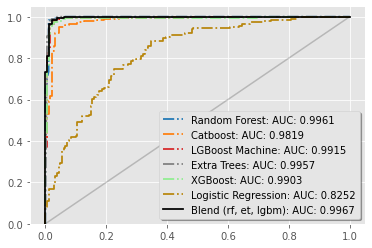

In [3]:
import matplotlib as plt
plt.rcParams["figure.figsize"] = (6, 4)
exec(open('ML_sdms_predict.py').read())

In [4]:
f_score

,Extra Trees,Random Forest,"Blend (rf, et, lgbm)",LGBoost Machine,XGBoost,Catboost,Logistic Regression
F-statistic :,0.983425,0.980716,0.978022,0.970027,0.964384,0.935829,0.753927


In [5]:
# blended (BRTs & RF) feature importance from the validation set
#len(data[data.pa == 1])
#len(data[data.pa == 0])
#len(validation_class[validation_class == 0])
#  xv-18, 107: .9969, 0.967033, xv-21, 110: .9973, .978 
feature_importances[len(feature_importances)-1]

Weight,Feature
0.0608 ± 0.0061,bclim8
0.0398 ± 0.0190,bclim12
0.0265 ± 0.0142,bclim6
0.0249 ± 0.0078,bclim15
0.0166 ± 0.0175,bclim18
0.0144 ± 0.0095,bclim4
0.0122 ± 0.0166,bclim14
0.0116 ± 0.0142,bclim2
0.0088 ± 0.0081,bclim9
0.0077 ± 0.0118,bclim11


### Part 3: Geospatial Predictions of Species Distributions

---

In [6]:
from pyimpute import load_training_vector
from pyimpute import load_targets
from pyimpute import impute

In [7]:
import glob 
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
# grab features, see Appendix section 1 below for feature selection methods
explanatory_rasters = ['bclim11', 'bclim12', 'bclim14', 'bclim15', 'bclim18',
               'bclim2', 'bclim3', 'bclim4', 'bclim6', 'bclim7', 'bclim8','bclim9']
i = 0
for f in explanatory_rasters:
    explanatory_rasters[i] = ('data_2.0/train-rasters-2.5m/' + f + '.asc')
    i = (i + 1)
print('\nThere are', len(explanatory_rasters), '.asc features.') # check there are ten 
# grab shapefile containing 100% of the final presence/absence locations
response_data = gpd.GeoDataFrame.from_file('data_2.0/geofile-xv-presences/xv_two_step.shp')
response_data.drop(287, axis = 0, inplace = True) # drop coordinate above pinnacles
response_data.head(10) # check geopandas data 


There are 12 .asc features.


,CLASS,geometry
0,1.0,POINT (-120.65644 36.51553)
1,0.0,POINT (-112.27083 37.47917)
2,0.0,POINT (-111.60417 32.06250)
3,1.0,POINT (-119.41123 34.82431)
4,0.0,POINT (-116.10417 37.93750)
5,1.0,POINT (-117.85117 34.65556)
6,1.0,POINT (-118.60656 34.78263)
7,1.0,POINT (-110.03113 37.59979)
8,1.0,POINT (-115.07847 36.69694)
9,1.0,POINT (-116.47987 34.70059)


In [8]:
print("number of duplicates: ", response_data.duplicated(subset='geometry', keep='first').sum())
print("number of NA's: ", response_data['geometry'].isna().sum())
print("Coordinate reference system is: {}".format(response_data.crs))
print("{} observations with {} columns".format(*response_data.shape))

number of duplicates:  0
number of NA's:  0
Coordinate reference system is: epsg:4326
1810 observations with 2 columns


We can map the species presences (`pa==1`).
* Coordinates downloaded from open-source repositories (GBIF) (Leavitt et al., 2007)
* Filtered erroneous, spatially biased, and duplicated data (907 X.v. & 1325 Y.b.)

number of species presences: 906



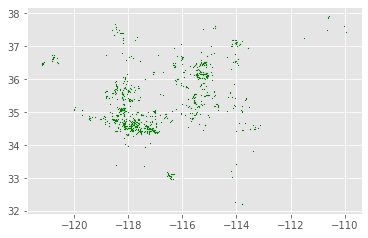

In [9]:
print('number of species presences:', len(response_data[response_data.CLASS == 1]))
response_data[response_data.CLASS == 1].plot(marker='.', color='green', markersize=2)
print('')

We can also map the background points (`pa==0`).

* Study space set from 109.3°W to 122.8°W and 31.9°N to 38.2°N
* Background points randomly drawn (same # presences), removed spatially biased and clear false negative (within 1 km radius of species presences) coordinates


number of background points: 904



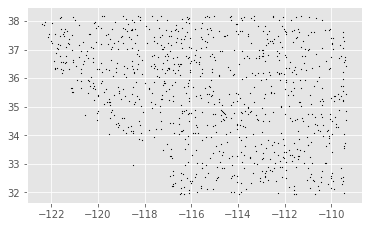

In [10]:
print('number of background points:', len(response_data[response_data.CLASS == 0]))
response_data[response_data.CLASS == 0].plot(marker='.', color='black', markersize=2)
print('')

In [11]:
# create pyimpute framework
train_xs, train_y = load_training_vector(response_data,
                                         explanatory_rasters,
                                         response_field='CLASS') 
train_xs.shape, train_y.shape # check shape

((1810, 12), (1810,))

In [12]:
# spatial prediction with the 3-model blended classifier
from sklearn import model_selection
import os
session_number = 'exp_id=101, xantusia_after'

target_xs, raster_info = load_targets(explanatory_rasters)
k = 5 
kf = model_selection.KFold(n_splits=k)
accuracy_scores = model_selection.cross_val_score(blender_specific, train_xs, train_y, cv=kf, scoring='accuracy')
print(name + " %d-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)"
          % (k, accuracy_scores.mean() * 100, accuracy_scores.std() * 200))
blender_specific.fit(train_xs, train_y)
# spatial prediction with impute function, saves tifs to file
#os.mkdir('outputs' + session_number)
#os.mkdir('outputs' + session_number + '/blender-baseline')
impute(target_xs, blender_specific, raster_info, outdir='outputs' + session_number + '/blender-baseline',
       class_prob=True, certainty=True)

Blend (rf, et, lgbm) 5-fold Cross Validation Accuracy: 87.24 (+/- 3.30)


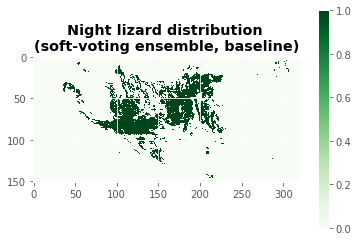

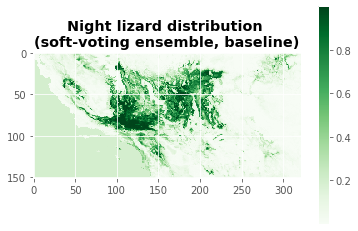

In [13]:
# plot the spatial output of the 3-model blended classifier
from pylab import plt
# define spatial plotter
def plotit(x, title, cmap="Blues"):
    plt.imshow(x, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title, fontweight = 'bold')
blended_curr = rasterio.open('outputs'+ session_number + '/blender-baseline/responses.tif')
plotit(blended_curr.read(1),'Night lizard distribution \n(soft-voting ensemble, baseline)',
        cmap='Greens')
plt.figure()
blended_curr = rasterio.open('outputs' + session_number + '/blender-baseline/probability_1.0.tif') 
plotit(blended_curr.read(1),'Night lizard distribution \n(soft-voting ensemble, baseline)',
       cmap='Greens')
print('')

### Part 4: Predicting Suitability Under Climate Change Scenarios
---
Part 4 is unable to re-run without additional data/scripts not contained in the Git repo, contact for further information.

In [15]:
# extrapolate model to 128 future scenarios
exec(open('future_projection.py').read())

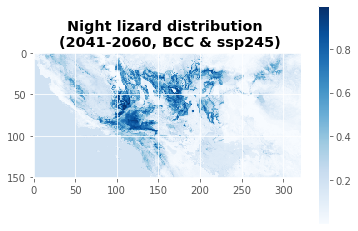

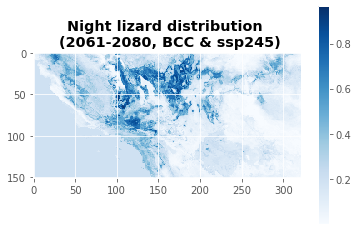

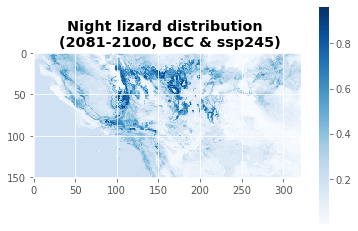

<Figure size 432x288 with 0 Axes>

In [17]:
for i in ['2041-2060','2061-2080','2081-2100']:
    future = rasterio.open('data_2.0/CMIP6_preds/ssp245_' + i + '/BCC/probability_1.0.tif').read(1)
    plotit(future, 'Night lizard distribution \n ('+ i + ', BCC & ssp245)')
    plt.figure()

### Appendix 1: Removing Correlated Features
---

Recursively selects de-correlated features for modeling below a Spearman's threshold, using the rank of feature importance scores.

---

In [20]:
exec(open('recursive-ranker.py').read())

In [22]:
# load csv files for recursion function
covariance = pd.read_csv('data_2.0/collinearity/xv-baseline.csv')
feature_importance = pd.read_csv('maxent/maxent_19_variables_xv/maxent-jacknife.csv')
recursive_ranker(covariance, feature_importance, 0.85,
                 pd.read_csv('data_2.0/collinearity/raw_data.csv'))

Comparing bclim16 or bclim19  | Dropping bclim16
Comparing bclim13 or bclim19  | Dropping bclim13
Comparing bclim1 or bclim10  | Dropping bclim10
Comparing bclim14 or bclim17  | Dropping bclim17
Comparing bclim12 or bclim19  | Dropping bclim19
Comparing bclim1 or bclim5  | Dropping bclim5
Comparing bclim1 or bclim11  | Dropping bclim1

final set of variables:  ['bclim11', 'bclim12', 'bclim14', 'bclim15', 'bclim18', 'bclim2', 'bclim3', 'bclim4', 'bclim6', 'bclim7', 'bclim8', 'bclim9']

Covariance matrix (r <  0.85 ):

         bclim11   bclim12   bclim14   bclim15   bclim18    bclim2    bclim3  \
bclim11      1.0  0.362862  0.599233  0.150592  0.321581  0.157325  0.083554   
bclim12      0.0  1.000000  0.180278  0.520403  0.097076  0.312577  0.354639   
bclim14      0.0  0.000000  1.000000  0.634341  0.831801  0.358903  0.495674   
bclim15      0.0  0.000000  0.000000  1.000000  0.714498  0.018052  0.623828   
bclim18      0.0  0.000000  0.000000  0.000000  1.000000  0.413657  0.574733 

### Appendix 2 : Feature Descriptions
---

**Description for features is as follows :**

|Variable|	Definition|	Units|   
|:---  |:--- |:---|
|BioClim11| Mean Temp of Coldest Quarter | $^o$C
|BioClim12| Annual Precipitation | mm
|BioClim14| Precip Driest Month| mm
|BioClim15| Precip Seasonality | (coefficient of variation)
|BioClim18| Precip Warmest Quarter | mm
|BioClim2| Diurnal Range | (Mean of monthly (max temp - min temp))
|BioClim3| Isothermality | (BIO2/BIO7) (×100)
|BioClim4| Temperature Seasonality | (standard deviation(C) ×100)|
|BioClim6| Min Temp Coldest Month| $^o$C
|BioClim7| Temp Annual Range| $^o$C
|BioClim8| Mean Temp Wettest Quareter | $^o$C
|BioClim9| Mean Temp Driest Quareter | $^o$C

**Description for the target variable is as follows :**

|Variable|	Definition|	Units|   
|:---  |:--- |:---|
|Pa| Binary class | 1 (presence) & 0 (background)

### Appendix 3 : Additional Model Comparisons
---

In [28]:
# Compare the blended ensemble to five tree-based classifiers
CLASS_MAP = {
    'rf': (rf),
    'et': (etrees),
    'xgb': (xgboost),
    'lgbm': (lgbm),
    'cb': (catboost)
    }
for name, (model) in CLASS_MAP.items():
    # Cross val for accuracy scores (as a %) for the entirety of the presence/background database
    k = 5 # k-fold
    kf = model_selection.KFold(n_splits=k)
    accuracy_scores = model_selection.cross_val_score(model, train_xs, train_y, cv=kf, scoring='accuracy')
    print(name + " %d-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)"
          % (k, accuracy_scores.mean() * 100, accuracy_scores.std() * 200))
    # spatial prediction
    model.fit(train_xs, train_y)
    #os.mkdir('outputs' + session_number + '/' + name + '-baseline')
    impute(target_xs, model, raster_info, outdir='outputs' + session_number + '/' + name + '-baseline',
           class_prob=True, certainty=True)


rf 5-fold Cross Validation Accuracy: 87.07 (+/- 3.11)
et 5-fold Cross Validation Accuracy: 87.24 (+/- 4.27)
xgb 5-fold Cross Validation Accuracy: 86.02 (+/- 4.34)
lgbm 5-fold Cross Validation Accuracy: 86.74 (+/- 2.45)
cb 5-fold Cross Validation Accuracy: 86.63 (+/- 3.06)


### Appendix 4 : Soft Voting Model Prams, MLFlow backend server
---

We first print the parameters for the three individual models which comprise the blended model, as well as the blended model itself, and then print the backend server log of our experiment. 

In [23]:
etrees

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=110, verbose=0,
                     warm_start=False)

In [24]:
lgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=110, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [25]:
catboost

In [26]:
blender_specific

TunableVotingClassifier(estimators=[('et',
                                     ExtraTreesClassifier(bootstrap=False,
                                                          ccp_alpha=0.0,
                                                          class_weight=None,
                                                          criterion='gini',
                                                          max_depth=None,
                                                          max_features='auto',
                                                          max_leaf_nodes=None,
                                                          max_samples=None,
                                                          min_impurity_decrease=0.0,
                                                          min_impurity_split=None,
                                                          min_samples_leaf=1,
                                                          min_samples_split=2,
                       

In [27]:
from pycaret.classification import get_logs
get_logs(experiment_name = 'xv-21')

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.AUC,metrics.Kappa,metrics.MCC,metrics.F1,...,tags.mlflow.runName,tags.Source,tags.Run Time,tags.Run ID,tags.mlflow.log-model.history,tags.mlflow.user,tags.USI,tags.mlflow.source.name,tags.URI,tags.mlflow.source.type
0,64da2aedba484bca84a97d6abf8a3d16,31,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-12-05 21:07:43.002000+00:00,2020-12-05 21:07:43.201000+00:00,0.000000,0.383500,0.429100,0.670700,...,SVM - Linear Kernel,compare_models,0.3,64da2aedba484bca84a97d6abf8a3d16,"[{""run_id"": ""64da2aedba484bca84a97d6abf8a3d16""...",danielfurman,bdba,/opt/anaconda3/lib/python3.7/site-packages/ipy...,78afb505,LOCAL
1,9d40d93fa4e646f28a4f1a33c59638c6,31,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-12-05 21:07:42.591000+00:00,2020-12-05 21:07:42.839000+00:00,0.835300,0.529300,0.539300,0.762200,...,Linear Discriminant Analysis,compare_models,0.34,9d40d93fa4e646f28a4f1a33c59638c6,"[{""run_id"": ""9d40d93fa4e646f28a4f1a33c59638c6""...",danielfurman,bdba,/opt/anaconda3/lib/python3.7/site-packages/ipy...,78afb505,LOCAL
2,0d9763f207ba427d9cbd3bbbc53433a2,31,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-12-05 21:07:42.198000+00:00,2020-12-05 21:07:42.411000+00:00,0.000000,0.529300,0.539300,0.762200,...,Ridge Classifier,compare_models,0.31,0d9763f207ba427d9cbd3bbbc53433a2,"[{""run_id"": ""0d9763f207ba427d9cbd3bbbc53433a2""...",danielfurman,bdba,/opt/anaconda3/lib/python3.7/site-packages/ipy...,78afb505,LOCAL
3,290aa26372be4111ad81ed2b0c2ccd77,31,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-12-05 21:07:41.864000+00:00,2020-12-05 21:07:42.051000+00:00,0.834400,0.535400,0.543100,0.766200,...,Logistic Regression,compare_models,1.25,290aa26372be4111ad81ed2b0c2ccd77,"[{""run_id"": ""290aa26372be4111ad81ed2b0c2ccd77""...",danielfurman,bdba,/opt/anaconda3/lib/python3.7/site-packages/ipy...,78afb505,LOCAL
4,a2171a5c5f5f4e649e0ac6cf8429fcbc,31,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-12-05 21:07:41.461000+00:00,2020-12-05 21:07:41.703000+00:00,0.858700,0.545200,0.555300,0.770500,...,Naive Bayes,compare_models,0.31,a2171a5c5f5f4e649e0ac6cf8429fcbc,"[{""run_id"": ""a2171a5c5f5f4e649e0ac6cf8429fcbc""...",danielfurman,bdba,/opt/anaconda3/lib/python3.7/site-packages/ipy...,78afb505,LOCAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,630108adb70d4b60a7e5e96b8efcf2f7,31,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-12-03 00:25:01.763000+00:00,2020-12-03 00:25:02.372000+00:00,0.934166,0.711614,0.714359,0.855543,...,Random Forest Classifier,create_model,4.17,630108adb70d4b60a7e5e96b8efcf2f7,"[{""run_id"": ""630108adb70d4b60a7e5e96b8efcf2f7""...",danielfurman,6e98,/opt/anaconda3/lib/python3.7/site-packages/ipy...,9aa09ea5,LOCAL
221,1073e6d61a704cce96060cb96d0ee24f,31,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-12-03 00:24:56.671000+00:00,2020-12-03 00:24:57.071000+00:00,0.930217,0.737274,0.741000,0.868322,...,CatBoost Classifier,create_model,25.74,1073e6d61a704cce96060cb96d0ee24f,"[{""run_id"": ""1073e6d61a704cce96060cb96d0ee24f""...",danielfurman,6e98,/opt/anaconda3/lib/python3.7/site-packages/ipy...,3f028743,LOCAL
222,91a7b8d5c3104467a51c9025e52004c0,31,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-12-03 00:24:30.165000+00:00,2020-12-03 00:24:30.541000+00:00,0.922604,0.703765,0.706356,0.851627,...,Extreme Gradient Boosting,create_model,3.28,91a7b8d5c3104467a51c9025e52004c0,"[{""run_id"": ""91a7b8d5c3104467a51c9025e52004c0""...",danielfurman,6e98,/opt/anaconda3/lib/python3.7/site-packages/ipy...,16a59a86,LOCAL
223,5103f5471a324d72b9124124fbc69c3b,31,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-12-03 00:24:25.778000+00:00,2020-12-03 00:24:26.438000+00:00,0.936462,0.731420,0.734520,0.865396,...,Extra Trees Classifier,create_model,7.43,5103f5471a324d72b9124124fbc69c3b,"[{""run_id"": ""5

### Appendix 5 : Citations
---

1. <a target="_blank" rel="noopener noreferrer" href="https://cran.r-project.org/web/packages/dismo/vignettes/sdm.pdf">Species distribution modeling with R</a> (Hijmans and Elith, 2017)
2. Pyimpute's <a target="_blank" rel="noopener noreferrer" href="https://github.com/perrygeo/pyimpute/blob/master/README.md">README.md</a>
3. A study <a target="_blank" rel="noopener noreferrer" href="https://www.researchgate.net/publication/229149956_Selecting_Pseudo-Absences_for_Species_Distribution_Models_How_Where_and_How_Many">on generating pseudo absence points</a>  (Barbet-Massin et al., 2012)
4. A study <a target="_blank" rel="noopener noreferrer" href="https://www.nature.com/articles/s41598-018-25437-1
">on SDM transferability and pixel size</a>  (Manzoor et al., 2018)
5.  A study <a target="_blank" rel="noopener noreferrer" href="https://onlinelibrary.wiley.com/doi/full/10.1111/ddi.13161">on SDMs for invasive species</a>  (Lake et al., 2020)
6. A book <a target="_blank" rel="noopener noreferrer" href="https://www.amazon.com/Mapping-Species-Distributions-Biodiversity-Conservation/dp/0521700027
">on mapping SDMs </a>  (Franklin, 2009)
7. A more modern <a target="_blank" rel="noopener noreferrer" href="https://damariszurell.github.io/SDM-Intro/"> SDMs tutorial</a> (Zurell, 2020) 
8. A study <a target="_blank" rel="noopener noreferrer" href="https://onlinelibrary.wiley.com/doi/full/10.1111/j.1600-0587.2012.07348.x">on collinearity among model variables</a> (C. F. Dormann et al., 2012) 

### Data Citations
---

1. GBIF.org (01 November 2020) GBIF Occurrence Download https://doi.org/10.15468/dl.ceutzd 
2. Fick, S.E. and R.J. Hijmans, 2017. WorldClim 2: new 1km spatial resolution climate surfaces for global land areas. International Journal of Climatology 37 (12): 4302-4315.



In [19]:
#exec(open('future_overlap.py').read())